In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
# 加载预训练的BERT模型和分词器
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# 加载数据
df = pd.read_csv('./all-data.csv', delimiter=',', encoding='latin-1')
df = df.rename(columns={'neutral':'sentiment', 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .':'Message'})
# 检查数据是否有缺失的值
print(df.isnull().sum())

sentiment    0
Message      0
dtype: int64


In [4]:
df = df.dropna()

In [5]:
# 将情绪标签映射为数字
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
df.sentiment = df.sentiment.map(sentiment_mapping)
# 划分训练集和测试集
train, test = train_test_split(df, test_size=0.2 , random_state=42)

In [6]:
# 加载预训练的 BERT 模型和分词器
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# 准备输入数据
train_encodings = tokenizer(train.Message.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test.Message.tolist(), truncation=True, padding=True, max_length=128)
# 创建数据集
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train.sentiment.tolist()
)).shuffle(1000).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test.sentiment.tolist()
)).batch(16)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# 训练模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
model.fit(train_dataset, epochs=2)

Epoch 1/2
243/243 [==============================] - 833s 3s/step - loss: 0.5767 - accuracy: 0.7577
Epoch 2/2
243/243 [==============================] - 950s 4s/step - loss: 0.2783 - accuracy: 0.8971


61/61 [==============================] - 102s 2s/step


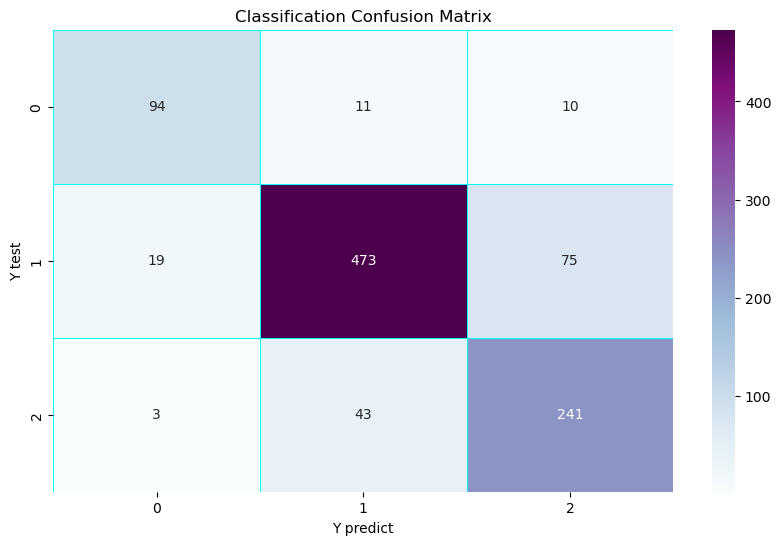

In [8]:
# 预测测试集
predictions = model.predict(test_dataset)
# 将预测结果转换为标签
pred_labels = np.argmax(predictions.logits, axis=1)
# 创建混淆矩阵
plt.figure(figsize=(10,6))
cm = confusion_matrix(test.sentiment, pred_labels)
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', cmap="BuPu")
plt.title('Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [9]:
# 预测新消息的情绪
def predict_sentiment(model, tokenizer, text):
    inputs = tokenizer(text, truncation=True, padding=True, max_length=128, return_tensors='tf')
    pred = model(inputs)
    labels = ['消极', '中性', '积极']
    print(f'"{text}" 的情绪是 {labels[np.argmax(pred.logits)]}')

In [10]:
predict_sentiment(model, tokenizer, '@elonmusk had a terrible experience with a very pushy sales guy from tesla Stanford shop while shopping for model x')

"@elonmusk had a terrible experience with a very pushy sales guy from tesla Stanford shop while shopping for model x" 的情绪是 消极
